# Instructions

The overall goal here is to find a Kepler target, get the lightcurve data, clean and normalize the data, then fit the transits. The bolded instructions below are the tasks which require the most human work, while most of the others will just require running the code which automatically performs the task. 

What needs to be turned in:
* This notebook with all of your code work edits
* Verify your solved period with a reliable online resource. Show that outsourced period and a link to the source(s). If your period is significantly different (>1 day), attempt to explain why. (you can write all this in the cell below)

**The steps:**

1) **Find a target star which hosts a giant planet companion which was observed by the Kepler mission**

2) Download the lightcurve fits files

3) Load the lightcurve data into your code

4) Normalize the lightcurve

5) Approximate the orbital period and the t0 using the box least squares method (BLS)

6) **Approximate the parameters of the transit fit**

7) Solve the transit fit using MCMC

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import csaps

In [6]:
%matplotlib notebook

# Filter and normalization function definitions

In [ ]:
# Takes in spectra
def normalize_region(wl, flux, ferr, sds, plot_q=True, ss_smo=1e-3):
    
    __, gi = stdFiltIt(wl, np.copy(flux), 
                       np.ones_like(flux), 
                       sds, smo=ss_smo, plot_q=plot_q)

    cont_fit = csaps.UnivariateCubicSmoothingSpline(wl[gi], 
                                                    flux[gi], 
                                                    smooth=ss_smo
                                                   )(wl)

    if plot_q:
        
        plt.figure(figsize=(10, 5))
        plt.plot(wl, flux, '.-k')
        plt.plot(wl, cont_fit, '-r')
        plt.title('Fit')
        plt.xlabel('time')
        plt.ylabel('Flux')
        
        plt.grid(1)
        
        plt.show()
    
    #####################################
    # Normalize continuum

    flux_norm = flux / cont_fit
    
    ferr_norm = ferr / cont_fit

    if plot_q:
        
        plt.figure(figsize=(10, 5))
        #plt.plot(wl, flux_norm, '.-k')
        plt.plot(wl, flux_norm, '-', c=[0.5, 0.5, 0.5], linewidth=1, label='Flux')
        
        if 1:
            plt.fill_between(wl, flux_norm - ferr_norm, flux_norm + ferr_norm, 
                             step='mid', 
                             color=[0.85, 0.85, 0.85], label='Flux Error')
        
        plt.axhline(1.0, color='m', linewidth=1, label='Continuum')
            
        plt.title('Normalized')
        
        plt.xlabel('time [day]')
        plt.ylabel('Flux [ppt]')
        
        plt.grid(1)
        
        plt.show()
    
    return flux_norm, ferr_norm


def wlr2ir(wl, wl_bounds):
    
    line_idx_bnds = [0, 0]

    line_idx_bnds[0] = np.argwhere(np.abs(wl - wl_bounds[0]) == np.nanmin(np.abs(wl - wl_bounds[0])))
    line_idx_bnds[1] = np.argwhere(np.abs(wl - wl_bounds[1]) == np.nanmin(np.abs(wl - wl_bounds[1])))

    # What indicies span within the wavelength bounds?
    return np.arange(line_idx_bnds[0], line_idx_bnds[1] + 1)


def stdFiltIt(wl, arr_1d, weights_1d, sdms, smo, plot_q):
    
    if plot_q:
        plt.figure(figsize=(10, 5))
        plt.title('Filter plot')
        plt.plot(wl, arr_1d, '.k')

    fit = arr_1d + np.nan
    
    for sdm in sdms:

        gi = np.logical_and(np.isfinite(weights_1d), np.isfinite(arr_1d))
        
        fit = csaps.UnivariateCubicSmoothingSpline(wl[gi], arr_1d[gi], smooth=smo)(wl)

        dy_sd = np.std(arr_1d[gi] - fit[gi]) * sdm

        gi = np.logical_and(np.abs(arr_1d - fit) <= dy_sd, gi)

        if plot_q:
            plt.plot(wl[np.logical_not(gi)], arr_1d[np.logical_not(gi)], 'xr')
            plt.plot(wl, fit + dy_sd, ':g')
            plt.plot(wl, fit - dy_sd, ':r')
            plt.grid(True)

        arr_1d[np.logical_not(gi)] = np.nan

    if plot_q:
        plt.show()

    return arr_1d, gi

# Load a lightcurve

In [ ]:
from astropy.io import fits
from os import listdir

#data_dir0 = '/media/etdisk1/kepdata/data/lightcurves/011446443/'
data_dir0 = '/media/etdisk1/kepdata/data/lightcurves/005792202/' # http://www.openexoplanetcatalogue.com/planet/Kepler-27%20c/

###

kid = 3

data_dir = data_dir0 + listdir(data_dir0)[kid]

hdu = fits.open(data_dir)


time = hdu[1].data.field(0)

flux = hdu[1].data.field(7)

flux_err = hdu[1].data.field(8)


import lightkurve as lk

lc = lk.LightCurve(time=time[:], flux=flux[:], flux_err=flux_err[:])

# Or download a light curve

**Search for data of a specific target**

In [ ]:
# target_name = '005792202'

target_name = '11812062'

#target_name = 'Kepler-432'

# target_name = 'Kepler-88'

# target_name = 'Kepler-470'

In [ ]:
from lightkurve.search import search_lightcurvefile

res = search_lightcurvefile(target_name, radius=None, 
                            cadence='long', mission=('Kepler', 'K2', 'TESS'), 
                            quarter=None, month=None, campaign=None, sector=None, limit=10)

res

**Download the data and stitch all the quartly data together into one light curve**

In [ ]:
#quality bitmask --> "hard" --> anything that's not 'good' won't be included in the dataset
lc = res.download_all(quality_bitmask='hard')

#don't use try-except unless you can't avoid it...you *shouldn't* need it
try:
    lc = lc.stitch()
    #stitches all light cuves together
except:
    pass

lc

# Check the size of the data array

If the array is over 50,000 elements, the following processes will take a long time. If too long, the processes also might fail due to running out of memory (dependent on how much memory your PC has).

In [ ]:
len(lc.time)

If the size of the array is too large, you should bin the data to reduce its size.

Binning will combine datapoints to make a smaller dataset.

For example, 

T = [t1, t2, t3, t4, t5, t6, ...]

binning T by 2 would combine the elements in T like so,

T_binned_by_2 = [mean(t1, t2), mean(t3, t4), mean(t5, t6), ...]

such that the bined array has length of len(T) / 2

In [ ]:
if 0: #if too big
    lc = lc.bin(binsize=5)

# Filter NaN's out of the dataset

In [ ]:
lc = lc.remove_nans()

time, flux, flux_err = lc.time, lc.flux, lc.flux_err

New array length after binning (if binning enabled)

In [ ]:
len(time)

# Plot the original lightcurve data

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(time, flux, '.k')
plt.grid(1)
plt.show(block=0)
plt.xlabel('time [day]')
plt.ylabel('flux [ppt]');

# Normalize the light curve

1st plot shows the results of the iterative standard deviation filter process

2nd plot shows the fit

3rd plot shows the result of flux normalization


This process will likely require you to edit the "sds" and/or "ss_smo" variables. The sds variable can be a list or a numpy 1D array. It constains the standard deviation multiplier for each iteration of the filter. The length of "sds" will set the number of iterations the filter runs. Typically, you want to start with a large multiplier and slowly reduce the multiplier. How high and how low the multiplier should be is dependent on the data. Here are some general rules for choosing the values in sds:

* If your data has very large outliers, you need to start with a very large multiplier. If you dont, you risk filtering out large amounts of good data, which is catastrophic.
* If your data has very few outliers, you can start with a low multiplier to speed up the process. This is optional and, in general, causes no harm.
* You need to CLOSELY look at your filtered data (plot 1) and make sure you are filtering out as much transit data as possible, even if you begin to cut into a small amount of good data! If you see that the filter did not get rid of all transit datapoints, you need to set a lower sds final multiplier
* Along the length of your lightcurve you should not be filtrering large amounts of data. If you are, you need to increase the final multiplier value

Typically, the optimal values in sds will look similar to this (quick decrease in high values, then slow at the final smaller values):

sds = [5, 4, 3, 2.8, 2.5, 2.5]

You can manually set sds, or use np.linspace to automatically set the values.

In [ ]:
#standard deviations, this will control how many loops
# it goes through when looping
#ex. go from big std.devs to get rid of the huge ouliers, then go through and get smaller ones too
#ex. 1.5 to 1.9 to maybe filter out less?
#start with bigger value then adjust if needed
sds = np.linspace(7, 1.5, 5) 

flux_norm, ferr_norm = normalize_region(time, 
                                        flux,          
                                        flux_err,      
                                        sds,           # Standard deviation multiplier for each iteration of the filter
                                        plot_q=True,   # Show filter and fit plots
                                        #ss_smo=0.99    # Smoothing spline smooth level
                                        ss_smo=0.5    # Smoothing spline smooth level
                                       )

# Replace the flux and flux error data with the normalized versions we just created

In [ ]:
lc.flux = flux_norm
lc.flux_err = ferr_norm

# Plot the normalized data

You should stop here and closely look at your normalized data to make sure there are no problematic regions where, for example:

* normalization was not done propely (seen as longterm curvature) or 
* transits have been removed due to overfitting with a spline that was too relaxed (hard to tell, but can be seen if you compare to the original data).

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(time, flux_norm, '.k')
plt.show()

In [7]:
# target_name = '11812062'
# target_name = '12644822'
# target_name = '6863998'

target_name = '6276477'
# target_name = '10854555'

#target_name = '10480982'

# target_name = '6721123'

# kid = 12644822
# kid = 11812062

<IPython.core.display.Javascript object>


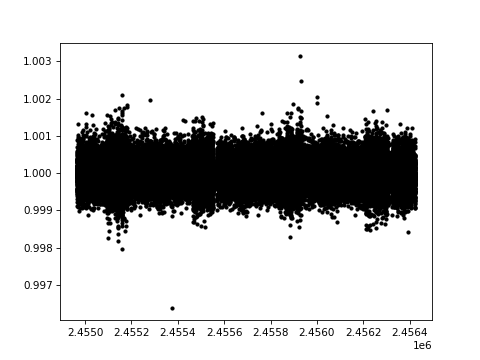

In [8]:
loaded_file = np.load('/media/rd3/cchen/cchen/kepler_ml_v3/norm_lcs/v2/all_kepler/' + str(target_name) + '_filt.npz')
timetest =  loaded_file['time']
fluxtest =  loaded_file['flux'] 

plt.figure()
plt.plot(timetest, fluxtest, '.k')

In [9]:
# realper = 162.52415
# realper = 171.63799
# realper = 173.25257
#realper = 174.4426
# realper = 188.6452

#realper = 197.78177

# realper = 195.97264
realper = 192.47028

idx = np.argmin(np.abs(realper - np.linspace(100,200,44000)))
print(idx)

40686


# The box least squares (BLS) function definition

In [49]:
def get_per(t, f, per_bounds=[1, 100], zoom_time_wdith=1.0):
    
    # Use box least squares (BLS) method to find the period and t0 for the transit
    
    gi = np.isfinite(t + f)
    
    t = t[gi]
    f = f[gi]
    
    
    # https://exoplanet.dfm.io/en/stable/tutorials/together/

    from astropy.timeseries import BoxLeastSquares

    m = np.zeros(len(t), dtype=bool)
#     period_grid = np.exp(np.linspace(np.log(per_bounds[0]), np.log(per_bounds[1]), 10000))
    period_grid = np.exp(np.linspace(np.log(per_bounds[0]), np.log(per_bounds[1]), 44000))
    bls_results = []
    periods = []
    t0s = []
    depths = []

    # Compute the periodogram for each planet by iteratively masking out
    # transits from the higher signal to noise planets. Here we're assuming
    # that we know that there are exactly two planets.
    for i in range(1):
        bls = BoxLeastSquares(t[~m], f[~m])
        bls_power = bls.power(period_grid, 0.1, oversample=20)
        bls_results.append(bls_power)

        # Save the highest peak as the planet candidate
        index = np.argmax(bls_power.power)
        periods.append(bls_power.period[index])
        t0s.append(bls_power.transit_time[index])
        depths.append(bls_power.depth[index])

        # Mask the data points that are in transit for this candidate
        #m |= bls.transit_mask(t, periods[-1], 0.5, t0s[-1])
        
        
        
    fig, axes = plt.subplots(len(bls_results), 2, figsize=(10, 5))

    for i in range(len(bls_results)):
        # Plot the periodogram
        if len(bls_results) > 1:
            ax = axes[i, 0]
        else:
            ax = axes[0]
        ax.axvline(np.log10(periods[i]), color="C1", lw=5, alpha=0.8)
        ax.plot(np.log10(bls_results[i].period), bls_results[i].power, "k")
        ax.annotate(
            "period = {0:.4f} d".format(periods[i]),
            (0, 1),
            xycoords="axes fraction",
            xytext=(5, -5),
            textcoords="offset points",
            va="top",
            ha="left",
            fontsize=12,
        )
        ax.set_ylabel("bls power")
        ax.set_yticks([])
        ax.set_xlim(np.log10(period_grid.min()), np.log10(period_grid.max()))
        if i < len(bls_results) - 1:
            ax.set_xticklabels([])
        else:
            ax.set_xlabel("log10(period)")

        # Plot the folded transit
        if len(bls_results) > 1:
            ax = axes[i, 1]
        else:
            ax = axes[1]
        p = periods[i]
        x_fold = (t - t0s[i] + 0.5 * p) % p - 0.5 * p
        m = np.abs(x_fold) < zoom_time_wdith
        ax.plot(x_fold[m], f[m], ".k")

        # Overplot the phase binned light curve
        bins = np.linspace(-zoom_time_wdith, zoom_time_wdith, np.int64(32/0.4*zoom_time_wdith))
        denom, _ = np.histogram(x_fold, bins)
        num, _ = np.histogram(x_fold, bins, weights=f)
        denom[num == 0] = 1.0
        ax.plot(0.5 * (bins[1:] + bins[:-1]), num / denom, color="C1")

        ax.set_xlim(-zoom_time_wdith, zoom_time_wdith)
        ax.set_ylabel("relative flux [ppt]")
        if i < len(bls_results) - 1:
            ax.set_xticklabels([])
        else:
            ax.set_xlabel("time since transit")

    fig.subplots_adjust(hspace=0.02)
    
    return periods[0], t0s[0]

# Use box least squares (BLS) method to find the period and t0 for the transit

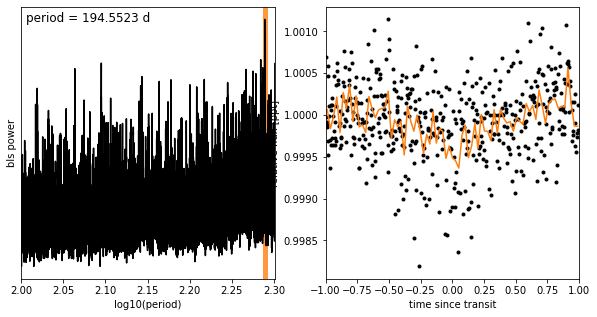

In [51]:
p, t0 = get_per(timetest, fluxtest, 
                per_bounds=[192.47028,192.47028], # Give a lower and upper bound period for the transit search
                zoom_time_wdith=1.0   # Days shown to the left and right of the transit in the left subplot
               )

In [ ]:
p = 173.25257
p, t0

# You can apply binning again if you needed extra data for finding the period and t0 from the BLS routine

It is ulikely that you need to apply binning here

In [ ]:
if 0:
    
    lc = lc.bin(binsize=10)

# Function definitions for transit fitting which is solved by the Markov chain Monte Carlo (MCMC) method

https://en.wikipedia.org/wiki/Markov_chain_Monte_Carlo

In [8]:
import exoplanet as xo
import pymc3 as pm

def create_mcmc_model(t, f, ferr, pm, ig):
    
    import pymc3 as pm

    with pm.Model() as model:

        # The baseline flux (what most of the data is centered around; is it 1.0001 instead of 1.000?)
        # Randomly sampled from normal distribution
        mean = pm.Normal("mean", mu=ig['cont'], sd=ig['cont_sd'])

        # The time of a reference transit for each planet
        t0 = pm.Normal("t0", mu=ig['t0'], sd=ig['t0_sd'], shape=1)

        # The log period; also tracking the period itself
        logP = pm.Normal("logP", mu=np.log(ig['P']), sd=ig['P_sd'], shape=1)
        
        period = pm.Deterministic("period", pm.math.exp(logP))

        # The Kipping (2013) parameterization for quadratic limb darkening paramters
        u = xo.distributions.QuadLimbDark("u", testval=np.array([ig['limb_dark_u']]))

        r = pm.Uniform("r", lower=ig['r_ratio_lb'], upper=ig['r_ratio_ub'], shape=1, testval=np.array([ig['r_ratio_sv']]))
        
        b = xo.distributions.ImpactParameter("b", ror=r, shape=1, testval=ig['limb_dark_b'])
        
        
        # 
        rs = pm.Normal("r_star", mu=ig['r_star'], sd=10.0, shape=1)
        #ms = pm.Normal("m_star", mu=ig['m_star'], sd=10.0, shape=1)

        # Set up a Keplerian orbit for the planets
        #orbit = xo.orbits.KeplerianOrbit(period=period, t0=t0, b=b, r_star=rs, m_star=ms)
        orbit = xo.orbits.KeplerianOrbit(period=period, t0=t0, b=b, r_star=rs, m_star=1.0)

        # Compute the model light curve using starry
        light_curves = xo.LimbDarkLightCurve(u).get_light_curve(orbit=orbit, r=r, t=t)
        
        light_curve = pm.math.sum(light_curves, axis=-1) + mean

        # Here we track the value of the model light curve for plotting purposes
        pm.Deterministic("light_curves", light_curves)

        # In this line, we simulate the dataset that we will fit
        sim = xo.eval_in_model(light_curve)
        #sim += yerr * np.random.randn(len(sim))

        # The likelihood function assuming known Gaussian uncertainty
        pm.Normal("obs", mu=light_curve, sd=ferr, observed=f)

        # Fit for the maximum a posteriori parameters given the simuated
        # dataset
        #input_kwargs = {'tol':1}

        map_soln = xo.optimize(start=model.test_point)#, **input_kwargs)

            
    return model, pm, map_soln, sim


def plot_mcmc_model(t, f, ferr, pm, ig, plts):
    
    import pymc3 as pm
    
    with pm.Model() as model:

        # The baseline flux
        mean = pm.Normal("mean", mu=ig['cont'], sd=ig['cont_sd'])

        # The time of a reference transit for each planet
        t0 = pm.Normal("t0", mu=ig['t0'], sd=ig['t0_sd'], shape=1)

        # The log period; also tracking the period itself
        logP = pm.Normal("logP", mu=np.log(ig['P']), sd=ig['P_sd'], shape=1)
        
        period = pm.Deterministic("period", pm.math.exp(logP))

        # The Kipping (2013) parameterization for quadratic limb darkening paramters
        u = xo.distributions.QuadLimbDark("u", testval=np.array([ig['limb_dark_u']]))

        r = pm.Uniform("r", lower=ig['r_ratio_lb'], 
                       upper=ig['r_ratio_ub'], 
                       shape=1, 
                       testval=np.array([ig['r_ratio_sv']]))
        
        b = xo.distributions.ImpactParameter("b", ror=r, shape=1, testval=ig['limb_dark_b'])
        
        
        # 
        rs = pm.Normal("r_star", mu=ig['r_star'], sd=10.0, shape=1)
        #ms = pm.Normal("m_star", mu=ig['m_star'], sd=10.0, shape=1)

        # Set up a Keplerian orbit for the planets
        #orbit = xo.orbits.KeplerianOrbit(period=period, t0=t0, b=b, r_star=rs, m_star=ms)
        orbit = xo.orbits.KeplerianOrbit(period=period, t0=t0, b=b, r_star=rs, m_star=1.0)

        # Compute the model light curve using starry
        light_curves = xo.LimbDarkLightCurve(u).get_light_curve(orbit=orbit, r=r, t=t)
        
        light_curve = pm.math.sum(light_curves, axis=-1) + mean

        # Here we track the value of the model light curve for plotting purposes
        pm.Deterministic("light_curves", light_curves)

        # In this line, we simulate the dataset that we will fit
        sim = xo.eval_in_model(light_curve)
        
        if 1 in plts:
            plt.figure(figsize=(5, 5))
            plt.plot(t, f, ".k", ms=4, label="data")
            plt.plot(t, sim, lw=1, label="companion")
            plt.xlim(t.min(), t.max())
            plt.ylabel("relative flux")
            plt.xlabel("time [days]")
            plt.legend(fontsize=10)
            plt.title("map model")
        
        
        if 2 in plts:
            plt.figure(figsize=(15, 8))
            p = ig['P'][0]
            x_fold = (t - ig['t0'] + 0.5 * p) % p - 0.5 * p
            plt.errorbar(x_fold, f, yerr=ferr, fmt=".k", zorder=-1000)

            # Plot the folded model
            inds = np.argsort(x_fold)
#             inds = inds[np.abs(x_fold)[inds] < 1.6]
            inds = inds[np.abs(x_fold)[inds] < 3.6]
            #pred = map_soln["light_curves"][inds, n] + map_soln["mean"]
            #pred = np.median(pred, axis=0)
            plt.plot(x_fold[inds], sim[inds], color="m", label="model")
            plt.legend(fontsize=10, loc=4)
            #plt.xlim(-0.5 * p, 0.5 * p)
            plt.xlabel("time since transit [days]")
            plt.ylabel("relative flux")
            plt.title("KIC"+ target_name + " | Candidate period: " + str(p))
#             plt.xlim(-1.6, 1.6)
            plt.xlim(-3.6, 3.6)

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


# View our solved period and t0 to make sure they make sense

In [23]:
p, t0

(192.47024791478506, 2455142.6756476876)

In [13]:
type(p), type(t0)

(numpy.float64, numpy.float64)

In [ ]:
type(lc.time[0]), type(lc.flux[0]), type(lc.flux_err[0])

# Soving with MCMC reqires us to give good starting guesses for the transit fit

Below are all of the values that a proper tranist fit requires. The solve will try to solve these, but since there is so many variables, the solver needs us to give it reasonable starting guesses otherwise it will fail to solve properly. You should play with the cell below, changing the variables as needed until the fit matches the data closely.

Below are definitions for the variables and a tip on what alteration of that variable will do. The format is as follows:

* Variable Name - definition
    * What changing that variable will look like
    * Additional info

@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@

* 'cont' - baseline level. 
    * The average flux
    * Typically 1 since normalization sets it to 1.
    
    
* 'cont_sd' - Continuum standard deviation level. A solver parameter. 
    * You dont really need to touch this.
    
    
* 't0' - t0 [day]. Was solved in the BLS routine. Use the solved t0 here and add any corrections you need to it
    * Move the fit to the left or right
    
    
* 't0_sd' - t0 standard deviation level. A solver parameter. 
    * You dont really need to touch this.
    
    
* 'P' - orbital period [day]. Was solved in the BLS routine. Use the solved period here.
    * Changing this will change the quality of your light curve fold data. 
    * You probably shouldnt touch this since the solved period from the BLS routine is pretty robust when done correctly
    
    
* 'P_sd' - orbital period standard deviation level.A solver parameter. 
    * You dont really need to touch this.
    
    
* 'limb_dark_u' - Limb darkening parameter (u)
    * Changes the curvature at the edges and center of the transit fit
    * Lower values give lower curvature
    
    
* 'limb_dark_b' - Limb darkening parameter (b)
    * Changes the transit width
    
    
* 'r_ratio_sv' - radius ratio (r_p / r_sun)
    * Changes the transit depth
    
    
* 'r_ratio_lb' - radius ratio lower bound
    * The solver wont try radius ratio values lower than this
    
    
* 'r_ratio_ub' - radius ratio upper bound
    * The solver wont try radius ratio values higher than this

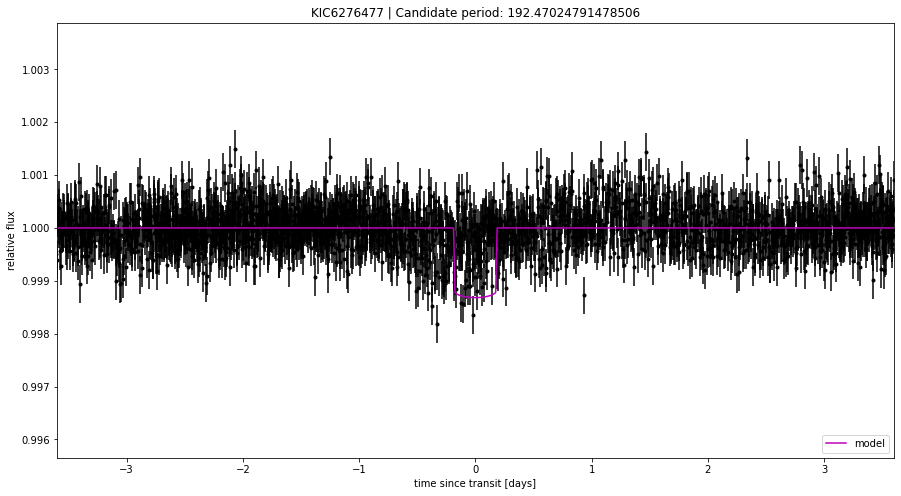

In [29]:
%matplotlib inline

if 1:
    ig = {'cont': 1.0,        # Continuum level
          'cont_sd': 1.0,     # Continuum standard deviation level
          't0':[t0 + 0.00],   # t0 [day]
          't0_sd':1.0,        # t0 standard deviation level
          'P':[p],            # period [day]
          'P_sd':1.0,         # period standard deviation level
          'limb_dark_u':0.1,# LD param - edge curvature 
          'limb_dark_b':0.15,  # LD param - transit width
          'r_ratio_sv':0.03, # radius ratio (r_p / r_sun) - depth of transit
          'r_ratio_lb':0.001, # radius ratio lower bound
          'r_ratio_ub':1.0,   # radius ratio upper bound
          'r_star':0.840,       # radius of primary star
          'm_star':1.0}       # mass of primary star

    
if 0:
    ig = {'cont': 1.0,        # Continuum level
          'cont_sd': 1.0,     # Continuum standard deviation level
          't0':[t0 + 0.00],   # t0 [day]
          't0_sd':1.0,        # t0 standard deviation level
          'P':[p],            # period [day]
          'P_sd':1.0,         # period standard deviation level
          'limb_dark_u':0.595,# LD param - edge curvature 
          'limb_dark_b':0.01,  # LD param - transit width
          'r_ratio_sv':0.058, # radius ratio (r_p / r_sun) - depth of transit
          'r_ratio_lb':0.001, # radius ratio lower bound
          'r_ratio_ub':1.0,   # radius ratio upper bound
          'r_star':2.2,       # radius of primary star
          'm_star':1.01}       # mass of primary star
    
    

if 0: # K-470
    ig = {'cont': 1.0,        # Continuum level
          'cont_sd': 1.0,     # Continuum standard deviation level
          't0':[t0 + 0.00],   # t0 [day]
          't0_sd':1.0,        # t0 standard deviation level
          'P':[p],            # period [day]
          'P_sd':1.0,         # period standard deviation level
          'limb_dark_u':0.595,# LD param - edge curvature 
          'limb_dark_b':0.0001,  # LD param - transit width
          'r_ratio_sv':0.098, # radius ratio (r_p / r_sun) - depth of transit
          'r_ratio_lb':0.001, # radius ratio lower bound
          'r_ratio_ub':1.0,   # radius ratio upper bound
          'r_star':1.2,       # radius of primary star
          'm_star':1.01}       # mass of primary star
    
plot_mcmc_model(timetest, fluxtest, np.std(fluxtest), pm, ig, plts=[2])

# Create a model of our transit and do an inital LSQ solve on the parameters to prepare it for the MCMC solver

In [30]:
# model, pm, map_soln, f_sim = create_mcmc_model(lc.time, lc.flux, lc.flux_err, pm, ig)

model, pm, map_soln, f_sim = create_mcmc_model(timetest, fluxtest, np.std(fluxtest), pm, ig)

optimizing logp for variables: [r_star, b, r, u, logP, t0, mean]


message: Desired error not necessarily achieved due to precision loss.
logp: 384731.0130855493 -> 385190.0561753731


# Plot definitions

In [31]:
def plot_pre_mcmc(t, f, ferr, map_soln):

    ###############################################################        

    plt.figure(figsize=(7, 5))
    plt.plot(t, f-1, ".k", ms=4, label="data")

    #if len(t0s) == 1:
    for i, l in enumerate("a"):
        plt.plot(t, map_soln["light_curves"][:, i], lw=1, label="planet {0}".format(l))
    #else:
    #    for i, l in enumerate("bc"):
    #        plt.plot(t, map_soln["light_curves"][:, i], lw=1, label="planet {0}".format(l))
    plt.xlim(t.min(), t.max())
    plt.ylabel("relative flux")
    plt.xlabel("time [days]")
    plt.legend(fontsize=10)
    plt.title("KIC" + target_name + " map model")

    ###############################################################

    
    planet_letters = 'a'

    for n, letter in enumerate(planet_letters):
        plt.figure(figsize=(7, 5))

        # Get the posterior median orbital parameters
        #if len(t0s) == 1:
        # (195.97262999999998, 2455061.227121864)
        #(192.47024791478506, 2455142.6756476876)
#         p = np.median(map_soln["period"])
#         t0 = np.median(map_soln["t0"])
        p = 192.47024791478506
        t0 = 2455142.6756476876
        #else:
        #    p = np.median(map_soln["period"][:, n])
        #    t0 = np.median(map_soln["t0"][:, n])
            
            
        print(p, t0)

        # Compute the median of posterior estimate of the contribution from
        # the other planet. Then we can remove this from the data to plot
        # just the planet we care about.
        #if len(t0s) == 1:
        other = np.median(map_soln["light_curves"][:, 0])
        #else:
        #    other = np.median(map_soln["light_curves"][:, (n + 1) % 2], axis=0)

        # Plot the folded data
        x_fold = (t - t0 + 0.5 * p) % p - 0.5 * p
        plt.errorbar(x_fold, f - other, yerr=ferr, fmt=".k", label="data", zorder=-1000)

        # Plot the folded model
        inds = np.argsort(x_fold)
#         inds = inds[np.abs(x_fold)[inds] < 0.6]
        inds = inds[np.abs(x_fold)[inds] < 1.6]
        pred = map_soln["light_curves"][inds, n] + map_soln["mean"]
        #pred = np.median(pred, axis=0)
        plt.plot(x_fold[inds], pred, color="C1", label="model")

        # Annotate the plot with the planet's period
        txt = "period = {0:.4f} +/- {1:.4f} d".format(np.mean(map_soln["period"][n]), 
                                                      np.std(map_soln["period"][n]))
        
        plt.annotate(txt,
                     (0, 0),
                     xycoords="axes fraction",
                     xytext=(5, 5),
                     textcoords="offset points",
                     ha="left",
                     va="bottom",
                     fontsize=12)

        plt.legend(fontsize=10, loc=4)
        #plt.xlim(-0.5 * p, 0.5 * p)
        plt.xlabel("time since transit [days]")
        plt.ylabel("relative flux")
        plt.title("KIC" + target_name + " planet {0}".format(letter))
#         plt.xlim(-0.6, 0.6)
        plt.xlim(-1.6, 1.6)

# See the LSQ solver results before solving with MCMC

If the fit failed here (looks bad), you need to try to give better starting value estimates

192.47024791478506 2455142.6756476876


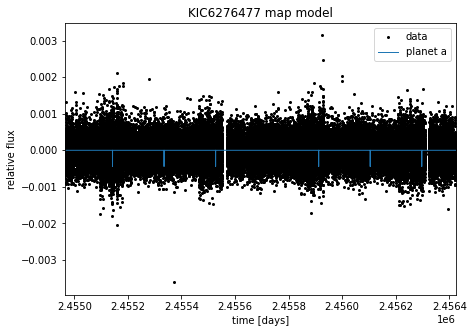

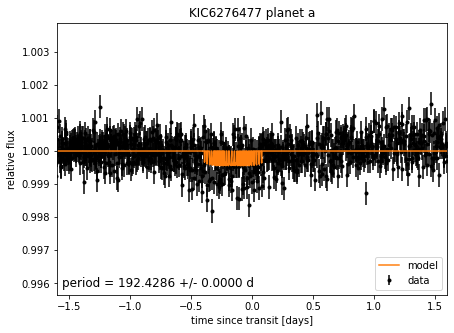

In [32]:
# plot_pre_mcmc(lc.time, lc.flux, lc.flux_err, map_soln)
plot_pre_mcmc(timetest, fluxtest, np.std(fluxtest), map_soln)

# Solve the transit with the MCMC solver!

In [33]:
np.random.seed(42)

with model:
    trace = pm.sample(tune=2000,
                      draws=2000,
                      start=map_soln,
                      chains=4,
                      step=xo.get_dense_nuts_step(target_accept=0.9))

Multiprocess sampling (4 chains in 4 jobs)
NUTS: [r_star, b, r, u, logP, t0, mean]


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 1029 seconds.
There were 19 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.8149659462581186, but should be close to 0.9. Try to increase the number of tuning steps.
There were 5 divergences after tuning. Increase `target_accept` or reparameterize.
There were 14 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.5772989119806692, but should be close to 0.9. Try to increase the number of tuning steps.
There were 16 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.40684020567237916, but should be close to 0.9. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated

# View the results of the solver

We can see the "mean" (highest likelyhood) and the "sd" (uncertainty) of the values we solved

In [39]:
mcmc_summary = pm.summary(trace, var_names=["period", "t0", "b", "u"])
# mcmc_summary = pm.summary(trace, var_names=['r_star', "period", "t0", "r", "b", "u", "mean"])

mcmc_summary

/opt/anaconda3/bin/arviz/data/io_pymc3.py:87: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
period[0],192.482,0.021,192.446,192.528,0.001,0.001,428.0,428.0,367.0,1158.0,1.26
t0[0],2455142.497,0.040,2455142.412,2455142.567,0.000,0.000,31225.0,31225.0,25.0,314.0,1.11
b[0],0.838,0.241,0.278,0.997,0.051,0.042,22.0,17.0,10.0,90.0,1.32
u[0],1.014,0.492,0.121,1.826,0.095,0.080,27.0,20.0,42.0,897.0,1.20
u[1],-0.212,0.440,-0.924,0.569,0.087,0.087,26.0,13.0,33.0,761.0,1.15


# View the probabillity distributions for the solved parameters

These plots show probabillity distributions for each parameter and they show likelyhood correlations between each parameter

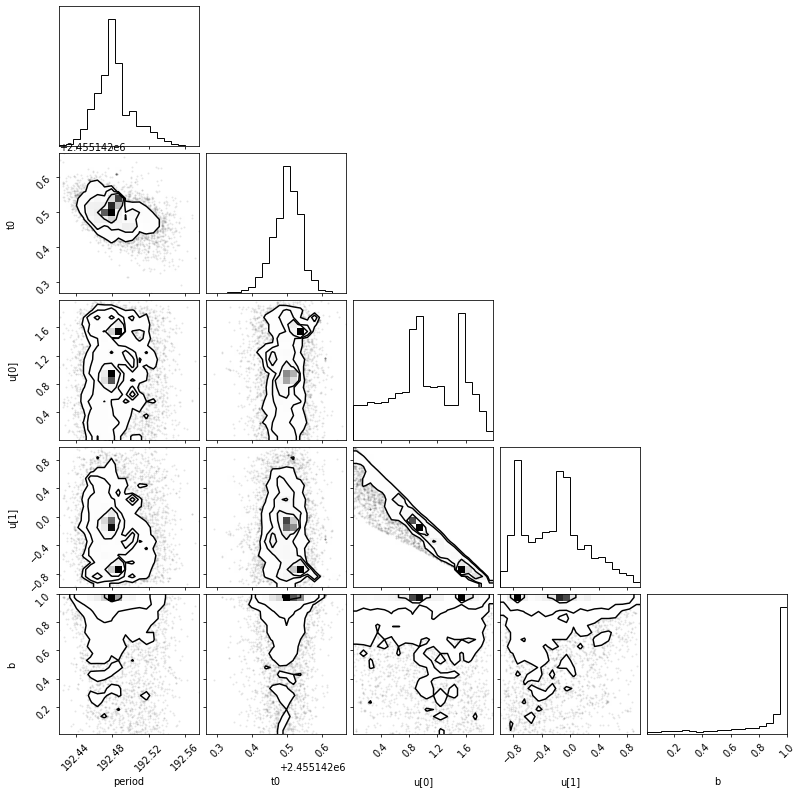

In [43]:
import corner

# samples = pm.trace_to_dataframe(trace, varnames=["period", "r"])
#truth = np.concatenate(xo.eval_in_model([period, r], model.test_point, model=model))

# figure = corner.corner(samples, labels=["period 1", "radius 1"])

# figure.set_dpi(70)

samples = pm.trace_to_dataframe(trace, varnames=['period', 't0', 'u', 'b'])
    
# samples = pm.trace_to_dataframe(trace, varnames=['r_star', 'period', 't0', "r", 'b', 'mean'])
#truth = np.concatenate(xo.eval_in_model([period, r], model.test_point, model=model))

figure = corner.corner(samples, labels=['period', 't0', 'u[0]', 'u[1]', 'b'])


# figure = corner.corner(samples, labels=['r_star', 'period 1', 't0', "radius 1", 'b', 'mean'])

# figure.title("KIC" + target_name + " Solved Parameters")

#figure.set_size_inches(8, 8)
figure.set_dpi(70)

#circle shows likelihood of correlation for period and radius, so center of circle is best fits
#it's a nice circle --> strong correlation

# Define a function to plot the highest likelyhood parameters as a fit on our data

In [35]:
def plot_mcmc_fit(t, f, ferr, trace):

    planet_letters = 'a'

    for n, letter in enumerate(planet_letters):
        plt.figure(figsize=(7, 5))

        # Get the posterior median orbital parameters
        p = np.median(trace["period"][:, n])
        t0 = np.median(trace["t0"][:, n])

        # Compute the median of posterior estimate of the contribution from
        # the other planet. Then we can remove this from the data to plot
        # just the planet we care about.
        #if len(t0s) == 1:
        other = np.median(trace["light_curves"][:, :, 0])
        #else:
        #other = np.median(trace["light_curves"][:, :, (n + 1) % 2], axis=0)

        # Plot the folded data
        x_fold = (t - t0 + 0.5 * p) % p - 0.5 * p
        plt.errorbar(x_fold, f - other, yerr=ferr, fmt=".k", label="data", zorder=-1000)

        # Plot the folded model
        inds = np.argsort(x_fold)
        inds = inds[np.abs(x_fold)[inds] < 1.6]
        pred = trace["light_curves"][:, inds, n] + trace["mean"][:, None]
        pred = np.median(pred, axis=0)
        plt.plot(x_fold[inds], pred, color="C1", label="model")

        # Annotate the plot with the planet's period
        txt = "period = {0:.4f} +/- {1:.4f} d".format(
            np.mean(trace["period"][:, n]), np.std(trace["period"][:, n])
        )
        plt.annotate(
            txt,
            (0, 0),
            xycoords="axes fraction",
            xytext=(5, 5),
            textcoords="offset points",
            ha="left",
            va="bottom",
            fontsize=12,
        )

        plt.legend(fontsize=10, loc=4)
        #plt.xlim(-0.5 * p, 0.5 * p)
        plt.xlabel("time since transit [days]")
        plt.ylabel("relative flux")
        plt.title("KIC " + target_name + " planet {0}".format(letter))
        plt.xlim(-1.6, 1.6)

# Plot the best fit for our data

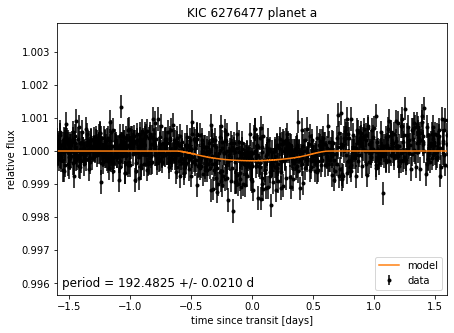

In [36]:
plot_mcmc_fit(timetest, fluxtest, np.std(fluxtest), trace)

#plt.ylim(None, 1+1e-3)

In [10]:
def signal(time_array, flux, period_id, t0=0.0, num_bins=8192):

    from kepler_utils import phase_fold_time, global_view
    
    time_array = phase_fold_time(time_array, period_id, t0)
    sorted_i = np.argsort(time_array)
    time_array = time_array[sorted_i]
    flux = flux[sorted_i]

    global_view = global_view(time_array, flux, period_id, num_bins=num_bins)
    
    t = np.linspace(np.min(time_array), np.max(time_array), num_bins)

    return t, global_view


def signal_no_bin(time_array, flux, period_id, t0):
    
    from kepler_utils import phase_fold_time

    time_array = phase_fold_time(time_array, period_id, t0)
    sorted_i = np.argsort(time_array)
    time_array = time_array[sorted_i]
    flux = flux[sorted_i]

    return time_array, flux

In [12]:
p = 192.47028
t0 = 2455142.497

In [13]:
t_bin, f_bin = signal_no_bin(timetest, fluxtest, p, t0)

t_fold, f_fold = signal(timetest, fluxtest, p, t0, num_bins=8192)

params_str = 'P='+ str(np.around(p, 1)) + '  t0='+ str(np.around(t0, 1))

lim = 15*6*6

plt.figure(figsize=(10,7))
# plt.title(target_name + ' | ' + params_str + ' | Folded Transit')
plt.plot(t_bin, f_bin, '.k')
plt.grid(1)
#plt.xlim(-5, 5)
# plt.xlim(-all_duration_day[interest_idx] * lim, all_duration_day[interest_idx] * lim)
# plt.xlim(-all_duration_day[interest_idx] * 6.5, all_duration_day[interest_idx] * 6.5)
plt.title("KIC " + str(target_name) + ' period: ' + str(p))
# plt.savefig('/media/rd3/cchen/cchen/kepler_ml_v3/norm_lcs/v2/hsps_v2/foldfigs/filtered/' + str(target_name) + '_filt0.png')
plt.show(block=False)
#plt.close()


plt.figure(figsize=(10,7))
# plt.title(target_name + ' | ' + params_str + ' | Folded & Binned Transit')
plt.plot(t_fold, f_fold, '.k')
plt.grid(1)
# plt.xlim(-all_duration_day[interest_idx] * lim, all_duration_day[interest_idx] * lim)
plt.title("KIC " + str(target_name) + ' period: ' + str(p))
# plt.savefig('/media/rd3/cchen/cchen/kepler_ml_v3/norm_lcs/v2/hsps_v2/foldfigs/filtered/' + str(target_name) + '_filt1.png')
plt.show(block=False)
#plt.show()

SyntaxError: invalid syntax (<ipython-input-13-2da0d670853a>, line 18)